# Correlation Analysis

This notebook examines some correlations

In [15]:
plot_formats = {
    'oxygen' : 'Oxygen Tolerance',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
}


In [231]:
df[(df['use_salinity'] == True) & (df['salinity_optimum'] < 0.1)]

,ncbi_taxid,strain_id,ncbi_species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,salinity_min,...,diff_extra_intra_aa_HM,diff_extra_intra_aa_YI,diff_extra_intra_aa_QC,diff_extra_intra_aa_YC,diff_extra_intra_aa_CM,diff_extra_intra_aa_NM,diff_extra_intra_aa_CH,diff_extra_intra_aa_MC,diff_extra_intra_aa_CN,diff_extra_intra_protein_coding_density
GCA_000701505,1121483.0,3777,Dyadobacter crusticola,7.00,7.0,7.0,25.0,0.05,0.500,0.00,...,-0.000071,-0.000532,-0.000242,-0.000196,-0.000144,0.000100,-0.000169,-0.000094,-0.000183,0.0
GCA_021129175,686831.0,10454,Chromobacterium piscinae,6.00,6.0,6.0,32.0,0.05,1.750,0.00,...,-0.000040,-0.000029,-0.000070,-0.000156,-0.000147,0.000109,-0.000164,-0.000121,-0.000048,0.0
GCA_021129195,467180.0,10453,Chromobacterium aquaticum,6.00,6.0,6.0,32.0,0.05,1.750,0.00,...,-0.000213,-0.000031,0.000010,-0.000179,-0.000097,0.000026,-0.000195,-0.000080,-0.000147,0.0
GCA_003201285,1763509.0,132396,Lachnotalea glycerini,7.00,7.0,7.0,30.0,0.03,2.265,0.03,...,-0.000213,-0.000693,-0.000177,-0.000242,-0.000139,0.000240,-0.000044,-0.000037,-0.000249,0.0
GCA_004766045,2018669.0,140297,Desulfosporosinus fructosivorans,7.75,7.5,8.0,20.0,0.05,1.750,0.00,...,-0.000060,-0.000066,-0.000330,-0.000334,-0.000190,0.000366,-0.000135,-0.000245,-0.000384,0.0


In [51]:
import datetime
import json
from glob import glob
import sys 
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('project.mplstyle')

sys.path.append("../")
from genome_spot.helpers import prepend_features, rename_condition_to_variable
from genome_spot.model_training.run_model_selection import BASE_VARS_AAS, BASE_VARS_DERIVED_GENOME, BASE_VARS_DERIVED_PROTEIN, BASE_VARS_PIS, ModelSelection
from genome_spot.model_training.taxonomy import TaxonomyGTDB
#from genome_spot.model_training.partition import PartitionTaxa
from genome_spot.model_training.balance import BalanceTaxa

In [17]:
conditions = ['oxygen', 'temperature', 'salinity', 'ph',  ]
targets = [rename_condition_to_variable(condition) for condition in conditions]

units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% w/v NaCl',
    'oxygen' : 'Probability Oxygen Tolerant'
}
units

{'temperature': '°C',
 'ph': 'pH',
 'salinity': '% w/v NaCl',
 'oxygen': 'Probability Oxygen Tolerant'}

In [18]:
feature_sets = ModelSelection().generate_named_feature_sets()
feature_set_dict = dict(feature_sets)
feature_set_dict.keys()

dict_keys(['aas', 'aas_by_compartment', 'aas_diff_compartment', 'pis', 'pis_by_compartment', 'pis_diff_compartment', 'derived', 'derived_by_compartment', 'derived_diff_compartment', 'all', 'all_by_compartment', 'all_diff_compartment'])

In [19]:
all_features = list(set([feat for features in feature_set_dict.values() for feat in features ]))
len(all_features)

174

In [20]:
localizations = ['all', 'intracellular_soluble',  'extracellular_soluble',  'membrane', 'diff_extra_intra']
rename_local = {
    'all' : 'No Localization',
 'extracellular_soluble' : 'Extracellular',
 'intracellular_soluble' : 'Intracellular',
 'membrane' : 'Membrane',
 'diff_extra_intra' : r'$\Delta$ Extra. vs Intra.',
}

In [21]:
rename_base_vars = {
    'nt_C' : 'G+C Content',
    'pur_pyr_transition_freq' : 'R>Y Transitions',
    'protein_coding_density' : 'Coding Density',
    'mean_protein_length' : 'Protein Length',
    'mean_gravy' : 'Hydropathy',
    'mean_nh2o' : 'nH2O',
    'mean_zc' : 'zC',
    'mean_pi' : 'pI',
    'proportion_R_RK' : 'R/R+K',
    'mean_thermostable_freq' : 'Thermostable Residues',
}
rename_base_vars.update({s : s.split('_')[-1] for s in BASE_VARS_AAS})
rename_base_vars.update({s : 'pI ' + '-'.join(s.split('_')[1:]) for s in BASE_VARS_PIS})
rename_base_vars

{'nt_C': 'G+C Content',
 'pur_pyr_transition_freq': 'R>Y Transitions',
 'protein_coding_density': 'Coding Density',
 'mean_protein_length': 'Protein Length',
 'mean_gravy': 'Hydropathy',
 'mean_nh2o': 'nH2O',
 'mean_zc': 'zC',
 'mean_pi': 'pI',
 'proportion_R_RK': 'R/R+K',
 'mean_thermostable_freq': 'Thermostable Residues',
 'aa_A': 'A',
 'aa_C': 'C',
 'aa_D': 'D',
 'aa_E': 'E',
 'aa_F': 'F',
 'aa_G': 'G',
 'aa_H': 'H',
 'aa_I': 'I',
 'aa_K': 'K',
 'aa_L': 'L',
 'aa_M': 'M',
 'aa_N': 'N',
 'aa_P': 'P',
 'aa_Q': 'Q',
 'aa_R': 'R',
 'aa_S': 'S',
 'aa_T': 'T',
 'aa_V': 'V',
 'aa_W': 'W',
 'aa_Y': 'Y',
 'pis_4_5': 'pI 4-5',
 'pis_5_6': 'pI 5-6',
 'pis_6_7': 'pI 6-7',
 'pis_7_8': 'pI 7-8',
 'pis_8_9': 'pI 8-9',
 'pis_9_10': 'pI 9-10',
 'pis_10_11': 'pI 10-11',
 'pis_11_12': 'pI 11-12'}

# Load data

In [22]:
df = pd.read_csv('../data/training_data/training_data_20231203.tsv', sep='\t', index_col=0)
all_targets = ['oxygen'] + ['use_salinity', 'use_temperature', 'use_ph',  'ph_max', 'ph_min', 'ph_optimum', 'ph_optimum_max', 'ph_optimum_min', 'salinity_max', 'salinity_midpoint', 'salinity_min', 'salinity_optimum', 'temperature_max', 'temperature_min', 'temperature_optimum', 'aerobe', 'anaerobe', 'microaerophile', 'facultative anaerobe', 'obligate aerobe', 'obligate anaerobe', 'facultative aerobe', 'aerotolerant', 'microaerotolerant']
df_features = df.loc[:, all_features]
df_targets = df.loc[:, all_targets]
df.shape, df_features.shape, df_targets.shape

((15576, 2266), (15576, 174), (15576, 25))

In [23]:
for col in ['salinity_optimum', 'temperature_optimum', 'ph_optimum', 'oxygen']:
    print(len(df[~df[col].isnull()]), col, 100*len(df[~df[col].isnull()])/len(df))

2374 salinity_optimum 15.241397021058038
4773 temperature_optimum 30.643297380585516
3545 ph_optimum 22.759373394966616
7293 oxygen 46.82203389830509


In [24]:
df['oxygen'].value_counts()


oxygen
1.0    5597
0.0    1696
Name: count, dtype: int64

In [25]:
for col in ['use_salinity', 'use_temperature', 'use_ph', 'use_oxygen']:
    print(col,len(df[df[col] == True]))

use_salinity 600
use_temperature 2418
use_ph 1020
use_oxygen 7293


In [28]:
from genome_spot.helpers import load_train_and_test_sets, rename_condition_to_variable

PATH_TO_HOLDOUTS = '../data/holdouts/'
#PATH_TO_HOLDOUTS = '../'
for condition in conditions:
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    
    print(len(train_set) + len(test_set), condition, df.loc[train_set + test_set, rename_condition_to_variable(condition)].mean())

3646 oxygen 0.6524958859023587
1722 temperature 33.031087882307396
465 salinity 6.025766711469533
756 ph 7.244411375661375


# Summary Statistics

In [29]:

taxonomy = TaxonomyGTDB()
len(taxonomy.taxonomy_dict.keys())

402709

In [30]:
diversity_rank = 'species'
rank = 'species'
long_set = set(taxonomy.measure_diversity(rank, diversity_rank).keys())#, subset_genomes=one_genome_per_species),
#sorted(long_set)

In [31]:
balancer = BalanceTaxa(taxonomy=taxonomy)
gtdb_species_with_genomes = len(balancer.select_genomes_at_rank(genomes=taxonomy.taxonomy_dict.keys(), rank='species', n_genomes=1))
bacdive_species_with_genomes = len(balancer.select_genomes_at_rank(genomes=df.index.tolist(), rank='species', n_genomes=1))
gtdb_species_with_genomes, bacdive_species_with_genomes

(85205, 12796)

In [32]:
len(df[~df['oxygen'].isnull()])

7293

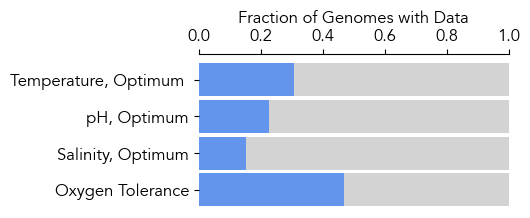

In [33]:
fig, ax = plt.subplots(figsize=(4,2))

bar_data = {}
for target in ['oxygen', 'salinity_optimum',  'ph_optimum','temperature_optimum']:
    nonnull = (~df[target].isnull()).sum()
    null = (df[target].isnull()).sum()
    bar_data[plot_formats[target]] = {'Reported' : (nonnull / (null + nonnull)), 'Not Reported' : (null / (null + nonnull))}
pd.DataFrame(bar_data).T.plot.barh(ax=ax, stacked=True, color=['cornflowerblue', 'lightgray'], legend=False, width=0.9)
#ax.legend(bbox_to_anchor=(0,0), frameon=False)
ax.set_xlabel('Fraction of Genomes with Data')
ax.set_xlim([0,1])
ax.set_ylabel('')
ax.set_ylim([-0.5, 3.7])
ax.xaxis.tick_top()
#to place the tick marks at the top of the image. The command
#ax.set_xlabel('X LABEL')    
ax.xaxis.set_label_position('top') 
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(True)

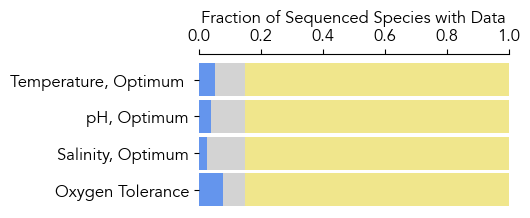

In [34]:


fig, ax = plt.subplots(figsize=(4,2))
bar_data = {}
for target in ['oxygen', 'salinity_optimum',  'ph_optimum','temperature_optimum']:

    nonnull_genomes = df[~df[target].isnull()].index.tolist()
    nonnull_species = len(balancer.select_genomes_at_rank(nonnull_genomes, rank='species', n_genomes=1)) 
    #null_genomes = df[df[target].isnull()].index.tolist()
    #null = (df[target].isnull()).sum()
    bar_data[plot_formats[target]] = {'Reported' : (nonnull_species / gtdb_species_with_genomes), 
                                      'Not Reported' : ((bacdive_species_with_genomes - nonnull_species) / gtdb_species_with_genomes),
                                      'asfsdf' : ((gtdb_species_with_genomes - bacdive_species_with_genomes) / gtdb_species_with_genomes)
                                     }


pd.DataFrame(bar_data).T.plot.barh(ax=ax, stacked=True, color=['cornflowerblue', 'lightgray', 'khaki'], legend=False, width=0.9)
#ax.legend(bbox_to_anchor=(0,0), frameon=False)
ax.set_xlabel('Fraction of Sequenced Species with Data')
ax.set_xlim([0,1])
ax.set_ylabel('')
ax.set_ylim([-0.5, 3.7])
ax.xaxis.tick_top()
#to place the tick marks at the top of the image. The command
#ax.set_xlabel('X LABEL')    
ax.xaxis.set_label_position('top') 
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(True)

(-2.0, 8.0)

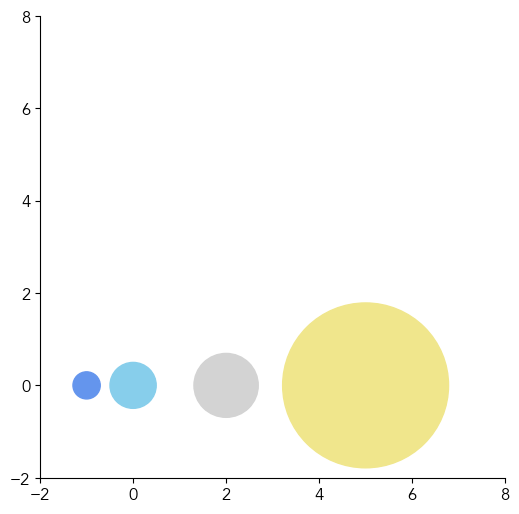

In [35]:
n_all = gtdb_species_with_genomes
n_bacdive = bacdive_species_with_genomes
n_oxygen = len(balancer.select_genomes_at_rank(df[~df['oxygen'].isnull()].index.tolist(), rank='species', n_genomes=1)) 
n_salinity = len(balancer.select_genomes_at_rank(df[~df['salinity_optimum'].isnull()].index.tolist(), rank='species', n_genomes=1)) 

def area_to_radius(n, full_area = 10):
    area_fraction = n / n_all
    area = full_area * area_fraction
    radius = np.sqrt(area / np.pi)
    return radius



circle4 = plt.Circle((-1, 0), area_to_radius(n_salinity, full_area = 10), color='cornflowerblue')
circle1 = plt.Circle((0, 0), area_to_radius(n_oxygen, full_area = 10), color='skyblue')
circle2 = plt.Circle((2, 0), area_to_radius(n_bacdive, full_area = 10), color='lightgray')
circle3 = plt.Circle((5, 0), area_to_radius(n_all, full_area = 10), color='khaki', clip_on=False)

fig, ax = plt.subplots(figsize=(6,6)) # note we must use plt.subplots, not plt.subplot

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
lims = [-2,8]
ax.set_xlim(lims)
ax.set_ylim(lims)

In [36]:
pd.DataFrame(bar_data)

,Oxygen Tolerance,"Salinity, Optimum","pH, Optimum","Temperature, Optimum"
Reported,0.077578,0.027005,0.040138,0.053225
Not Reported,0.072601,0.123174,0.110040,0.096954
asfsdf,0.849821,0.849821,0.849821,0.849821


oxygen <matplotlib.colors.LinearSegmentedColormap object at 0x15e2fb850>
0-0.75    0.232552
>0.75     0.767448
Name: oxygen, dtype: float64
0-0.75    1696
>0.75     5597
Name: oxygen, dtype: int64
oxygen 0.0 1.0
temperature_optimum <matplotlib.colors.LinearSegmentedColormap object at 0x15dc22f10>
0-15     0.020678
15-30    0.423490
30-45    0.450786
45-60    0.062862
60-80    0.035153
>80      0.007031
Name: temperature_optimum, dtype: float64
0-15       50
15-30    1024
30-45    1090
45-60     152
60-80      85
>80        17
Name: temperature_optimum, dtype: int64
temperature 4.0 105.0
salinity_optimum <matplotlib.colors.LinearSegmentedColormap object at 0x15dc22400>
0-0.5    0.045000
0.5-1    0.026667
1-2.5    0.236667
2.5-5    0.340000
5-10     0.185000
10-15    0.040000
>15      0.126667
Name: salinity_optimum, dtype: float64
0-0.5     27
0.5-1     16
1-2.5    142
2.5-5    204
5-10     111
10-15     24
>15       76
Name: salinity_optimum, dtype: int64
salinity 0.03 27.46821
ph_opti

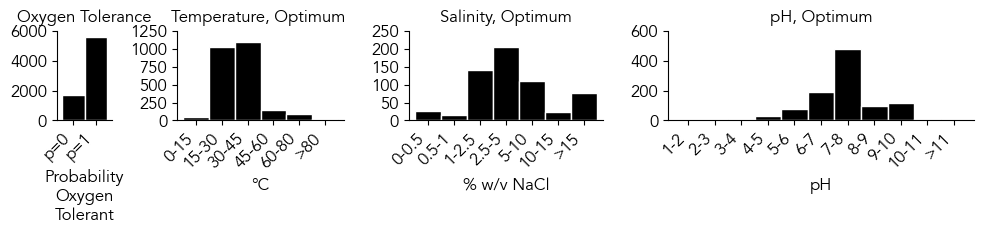

In [73]:
import matplotlib
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
bin_definitions = {
    'oxygen' : [0, 0.75],
    'ph_optimum' : np.arange(1,12,1),
    'temperature_optimum' : [0,15,30,45,60,80], #np.linspace(0,100,20), #np.percentile(optima_df['temperature'], 100 * np.linspace(0, 1, 100)), 
    'salinity_optimum' : [0, 0.5, 1, 2.5, 5, 10, 15],
}
oxygen_colors = ['dimgray', 'skyblue']
oxygen_cmap = LinearSegmentedColormap.from_list('my_cmap', oxygen_colors, N=2)
cmap_definitions = {target : plt.get_cmap("RdBu_r") for target in targets}
cmap_definitions['oxygen'] = oxygen_cmap
def colors_by_bin(target, bins, cmap_definitions):
    cmap = cmap_definitions[target]
    colors = [cmap(i/len(bins)) for i in range(len(bins))]
    return colors


# def distribution_df_by_target(target):
#     sers = []
#     bins = bin_definitions[target]
#     for name, group in genome_metadata_df.groupby(['biome1', 'biome2', 'habitat']):
#         for metagenome_id, group in group.groupby('metagenome_id'):
#             genome_ids = group['genome_id'].tolist()
#             binned_ser = histogram_by_values(optima_df, genome_ids, target, bins)
#             binned_ser.name = metagenome_id
#             sers.append(binned_ser)
    
#     n_bins = len(bins) 
#     blank_ser = pd.Series(dict(zip(range(1, n_bins + 1), [0] * n_bins)))
#     blank_ser.name = -1
#     sers.append(blank_ser)
    
#     dist_df = pd.DataFrame(sers).fillna(0).drop(-1)
#     dist_df = (dist_df.T / dist_df.sum(axis=1)).T
#     dist_df = dist_df.T.sort_index().T
#     return dist_df

def histogram_by_values(value_df, genome_ids, target, bins):
    values = value_df.reindex(genome_ids)[target].dropna()
    # hack to fix bad values currently.
    values.loc[values < bins[0]] = bins[0]
    # 
    binned_values = np.digitize(values, bins)
    binned_ser = pd.Series(Counter(binned_values)).reindex(range(1, len(bins) + 1)).fillna(0)
    binned_ser.name = target
    binned_ser.index = [f"{i}-{j}" for i,j in zip(bins, bins[1:])] + [f">{bins[-1]}"]
    return binned_ser

#fig, axes = plt.subplots(2,2,figsize=(5,5))
#fig, axes = plt.subplots(1,4,figsize=(10,2.5))

width_ratios = [len(bin_definitions.get(target)) for target in targets ]

fig, axes = plt.subplots(1,4,figsize=(10,2.5), gridspec_kw={'width_ratios' : width_ratios})
axl = axes.flatten()
for n, condition in enumerate(conditions):
    ax = axl[n]
    
    target = rename_condition_to_variable(condition)
    bins = bin_definitions[target]
    colors = colors_by_bin(target, bins, cmap_definitions)
    subset = df[df[f"use_{condition}"] == True][target].dropna().index
    n_all = len(df[target].dropna())
    n_subset = len(subset)
    ser = histogram_by_values(df, subset, target, bins)
    
    print(target, cmap_definitions[target])
    print(ser / ser.sum())
    ser.plot.bar(ax=ax, width=1, edgecolor='white', color='black')#colors)
    print(ser)
    if target == 'oxygen':
        ax.set_xticklabels(['p=0', 'p=1'], rotation=45, ha='right')
    else:
        xticklabels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(xticklabels, rotation=45, ha='right')
    xlabel = units[condition]
    
    if len(xlabel) > 25:
        ax.set_xlabel(xlabel.replace(' ', '\n'))
    else:
        ax.set_xlabel(xlabel)
    ax.set_title(plot_formats[target]) # + f"\nn={n_subset} / {n_all}"
    ax.set_yticks(ax.get_yticks())

    #ymin, ymax = ax.get_ylim()
    #ytext = 0.92 * (ymax - ymin) + ymin
    #xtext = 0.95 * (xmax - xmin) + ymin
    #ax.text(s=f'Total={ser.sum()}', x=-0.45, y=ytext, fontsize=10)
    #ax.set_xlim([-0.5,len(ser)-0.45])

    X = df[df[f"use_{condition}"] == True][target]
    print(condition, X.min(), X.max())
plt.tight_layout()

plt.savefig("fig-1b.svg",  format="svg")
plt.show()

In [236]:
sers = []
for condition in conditions:
    target = rename_condition_to_variable(condition)
    sers.append(df[(df[f"use_{condition}"] == True)][target].describe())
pd.concat(sers, axis=1)

,oxygen,temperature_optimum,salinity_optimum,ph_optimum
count,7293.000000,2418.000000,600.000000,1020.000000
mean,0.767448,32.276551,5.658274,7.207353
std,0.422488,11.106948,5.829491,1.324840
min,0.000000,4.000000,0.030000,1.100000
25%,1.000000,27.500000,2.000000,6.750000
50%,1.000000,30.000000,3.250000,7.250000
75%,1.000000,34.000000,7.000000,7.750000
max,1.000000,105.000000,27.468210,12.000000


In [71]:
ax.get_xticklabels()[0].get_text()

'1-2'

In [38]:
target = 'ph'
filter = (df[f'use_{target}'] == True) & (df[f'{target}_optimum'] <= 8) & (df[f'{target}_optimum'] >= 6)
df[filter].shape[0] / df[(df[f'use_{target}'] == True)].shape[0]


0.6774509803921569

In [39]:
filter = (df['use_oxygen'] == True)
len(df[filter & (df['oxygen'] == 1)]) / len(df[filter])

0.7674482380364733

# Correlation of genomic features to growth conditions

In [40]:
heatmap_base_features = BASE_VARS_DERIVED_GENOME + BASE_VARS_DERIVED_PROTEIN + BASE_VARS_PIS + BASE_VARS_AAS
len(heatmap_base_features)

38

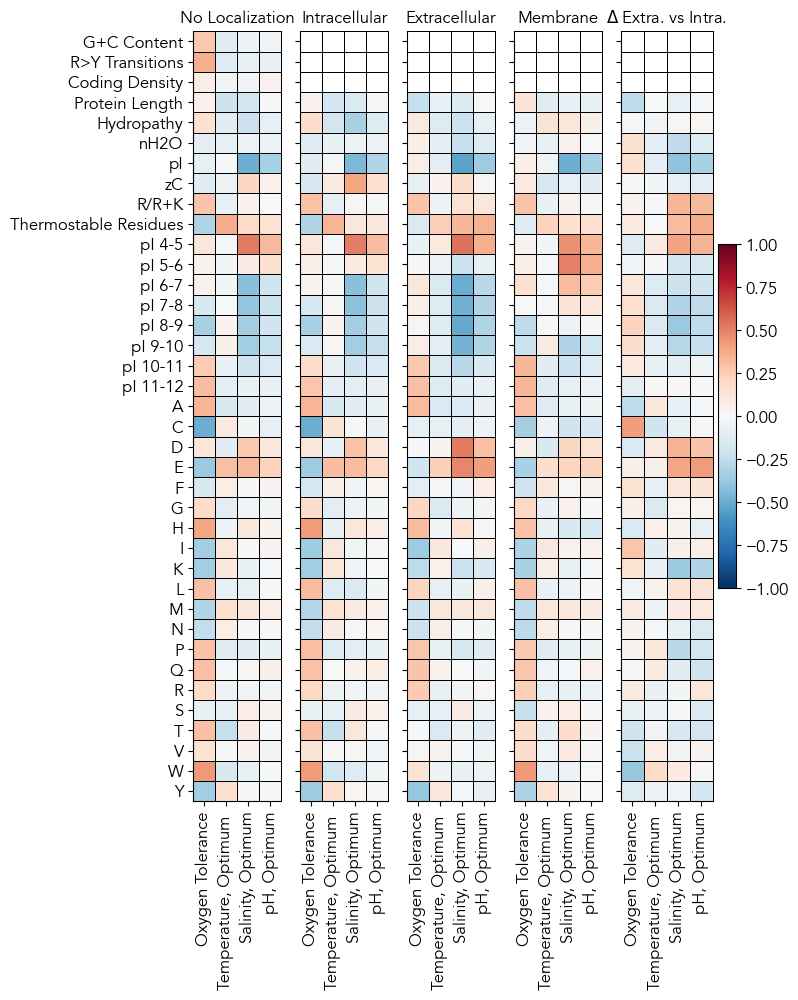

In [41]:

def axes_heatmaps_correlating_by_local(axes):

    for n, localization in enumerate(localizations):
        ax = axes[n]
        
        y_variables = heatmap_features = prepend_features(heatmap_base_features[::-1], [localization])
        x_variables = targets
        y_ticklabels = [rename_base_vars[y] for y in heatmap_base_features[::-1]]
        x_ticklabels = [plot_formats[x] for x in targets]
        
        X = df[x_variables + y_variables]
        method = 'spearman'
        C = X.corr(method=method).T
        c = ax.pcolormesh(range(len(x_variables)), range(len(y_variables)), 
                          C.loc[y_variables, x_variables].values, 
                          cmap='RdBu_r', vmin=-1, vmax=1, edgecolor='black', linewidth=0.5, clip_on=False)
        #ax.set_title(f'{method.capitalize()} Correlation Coefficients of Select Variables\n')
        ax.set_title(rename_local[localization].replace(' - ', ' -\n').replace('y L', 'y\nL'))
        ax.set_xticks(range(len(x_variables)))
        ax.set_yticks(range(len(y_variables)))
        ax.set_xticklabels(x_ticklabels, rotation=90, ha='center')
        
        
        #ax.axis([x.min(), x.max(), y.min(), y.max()])
        
        if n == 0:
            ax.set_yticklabels(y_ticklabels)
        else:
            ax.set_yticklabels([])
            
        if n == len(localizations) - 1:
            fig.colorbar(c, ax=ax,  aspect=20)
    return axes

fig, axes = plt.subplots(1,5,figsize=(7,10), gridspec_kw={'width_ratios' : (1,1,1,1,1.3)})
axes_heatmaps_correlating_by_local(axes)
plt.show()


0 18
0 16
2 17
4 16


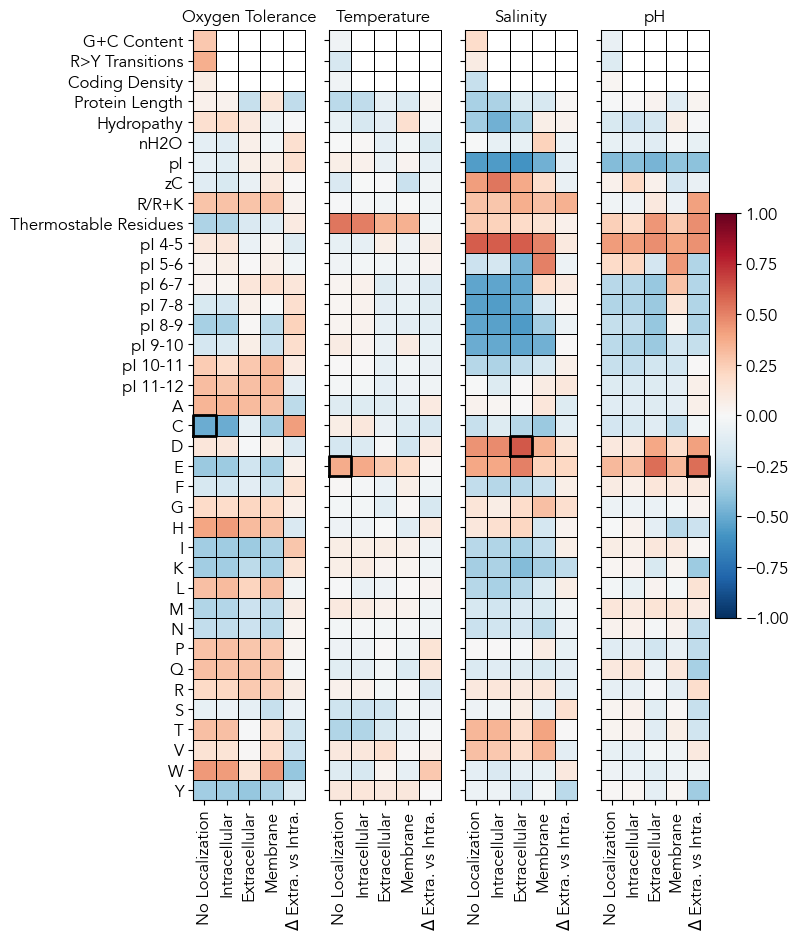

In [53]:
fig, axes = plt.subplots(1,4,figsize=(7,10), gridspec_kw={'width_ratios' : (1,1,1,1.2)})

all_all_features = []
for localization in localizations:
    all_all_features.extend(prepend_features(heatmap_base_features[::-1], [localization]))


highlight_relationships = {
    'temperature_optimum' : ('aa_E', 'all'),
    'ph_optimum' : ('aa_E', 'diff_extra_intra'),
    'salinity_optimum' : ('aa_D', 'extracellular_soluble'),
    'oxygen' : ('aa_C', 'all'),
}

for n, target in enumerate(targets):
    ax = axes[n]

    data = df[df[f"use_{target.replace('_optimum', '')}"] == True]
    X = data[targets + all_all_features]
    method = 'spearman'
    C_all = X.corr(method=method).T

    # grab 1 localization at a time
    C_sers = []
    for localization in localizations:
        ser = C_all.loc[target, prepend_features(heatmap_base_features[::-1], [localization])]
        ser.index = heatmap_base_features[::-1]
        C_sers.append(ser)
    
    C = pd.concat(C_sers, axis=1)
        
    #y_variables = heatmap_features = prepend_features(heatmap_base_features[::-1], [localization])
    x_variables = localizations
    y_ticklabels = [rename_base_vars[y] for y in heatmap_base_features[::-1]]
    x_ticklabels = [rename_local[x] for x in localizations]

    base_var, local = highlight_relationships[target]
    x_box = localizations.index(local)
    y_box = C.index.tolist().index(base_var)
    print(x_box, y_box)
    points = [(x_box-0.5, y_box-0.5), 
             (x_box-0.5, y_box+0.5),
             (x_box+0.5, y_box+0.5),
             (x_box+0.5, y_box-0.5),
             (x_box-0.5, y_box-0.5),
            ]
    ax.plot([tup[0] for tup in points], [tup[1] for tup in points], lw=2, color='black', clip_on=False)
    
    c = ax.pcolormesh(range(len(x_variables)), range(len(y_ticklabels)), 
                      C.values, 
                      cmap='RdBu_r', vmin=-1, vmax=1, edgecolor='black', linewidth=0.5, clip_on=False)
    #ax.set_title(f'{method.capitalize()} Correlation Coefficients of Select Variables\n')
    ax.set_title(plot_formats[target].replace(', Optimum', ''))
    ax.set_xticks(range(len(x_variables)))
    ax.set_yticks(range(len(y_ticklabels)))
    ax.set_xticklabels(x_ticklabels, rotation=90, ha='center')
    #rename_local[localization].replace(' - ', ' -\n').replace('y L', 'y\nL')
    
    #ax.axis([x.min(), x.max(), y.min(), y.max()])
    
    if n == 0:
        ax.set_yticklabels(y_ticklabels)
    else:
        ax.set_yticklabels([])
        
    if n == len(axes) - 1:
        fig.colorbar(c, ax=ax,  aspect=20)

plt.savefig("fig-1c.svg",  format="svg")
plt.show()

In [43]:
data[[x, target]].corr(method='spearman').iloc[0,1]

NameError: name 'x' is not defined

temperature_optimum 0.36843722735920775
ph_optimum 0.5567685050254689
salinity_optimum 0.621946649341914
oxygen -0.49295110672669834


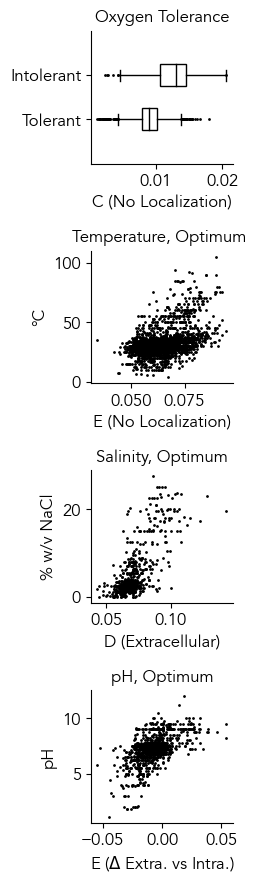

In [55]:
def get_color_by_corr(r):
    cmap = plt.get_cmap("RdBu_r")
    color = cmap((r+1)/2)
    return color
    
def ax_scatter_simple(base_var, local, target, color_by_corr =False):
    condition = target.replace('_optimum', '')
    x = f"{local}_{base_var}"
    data = df[~df[x].isnull() & ~df[target].isnull() & (df[f"use_{condition}"] == True)]
    r = data[[x, target]].corr(method='spearman').iloc[0,1]
    print(target, r)
    
    color ='black'
    if color_by_corr is True:
        color = get_color_by_corr(r)
    ax.scatter(data[x], data[target], s=1, alpha=1, color=color)
    ax.set_xlabel(rename_base_vars[base_var] + f' ({rename_local[local]})')
    ax.set_title(plot_formats[target])
    ax.set_ylabel(units[condition])
    return ax

def normalize_histogram(values, bins, norm = True):  
    digit_to_bin = dict(zip(range(1, len(bins)+1), list(bins) ))    
    binned_values = np.digitize(sorted(values), bins)
    counts = Counter(binned_values)
    if norm is True:
        counts = {k : v / len(binned_values) for k, v in counts.items()}
    binned_ser = pd.Series(counts).sort_index()
    X = binned_ser.index.map(digit_to_bin)
    Y = binned_ser.values
    return X, Y


fig, axes = plt.subplots(4,1, figsize=(2.6,9))
axl = axes.flatten()

ax = axl[1]
base_var, local, target = ('aa_E', 'all', 'temperature_optimum')
ax_scatter_simple(base_var, local, target)

ax = axl[3]
base_var, local, target = ('aa_E', 'diff_extra_intra', 'ph_optimum')
ax_scatter_simple(base_var, local, target)

ax = axl[2]
base_var, local, target = ('aa_D', 'extracellular_soluble', 'salinity_optimum')
ax_scatter_simple(base_var, local, target)

ax = axl[0]
base_var, local, target = ('aa_C', 'all', 'oxygen') 
x = f"{local}_{base_var}"
data = df[df[f"use_{target.replace('_optimum', '')}"] == True]
X_above = data[data[target] > 0.5][x].dropna().values
X_below = data[data[target] < 0.5][x].dropna().values

r = data[[x, target]].corr(method='spearman').iloc[0,1]
print(target, r)
color = get_color_by_corr(r)
color='white'
bins = np.linspace(0.00, 0.023, 46)
bplot = ax.boxplot([X_above,X_below], vert=False, widths=0.5, #colors=color, 
           flierprops={'markersize' : 1, 'color' : 'black'},medianprops={'color' : 'black'},
                   patch_artist=True,
          )
for patch in bplot['boxes']:
    patch.set_facecolor(color)
ax.set_ylim([-0,3])
ax.set_xlabel(x)
ax.set_yticklabels(['Tolerant', 'Intolerant'])
ax.set_title(plot_formats[target])
ax.set_xlabel(rename_base_vars[base_var] + f' ({rename_local[local]})')

plt.tight_layout()
plt.savefig("fig-1d.svg",  format="svg")
plt.show()

# Oxygen
## Simple Thresholds

In [310]:
oxygen_threshold = 0.012
data = df[df['use_oxygen'] == True]
len(data), data[data['all_aa_C'] >oxygen_threshold]['oxygen'].value_counts(), data[data['all_aa_C'] <= oxygen_threshold]['oxygen'].value_counts()

(7293,
 oxygen
 0.0    1050
 1.0     404
 Name: count, dtype: int64,
 oxygen
 1.0    5193
 0.0     646
 Name: count, dtype: int64)

0.012
0.10294335318729209
0.7119440552939459
0.6090007021066538


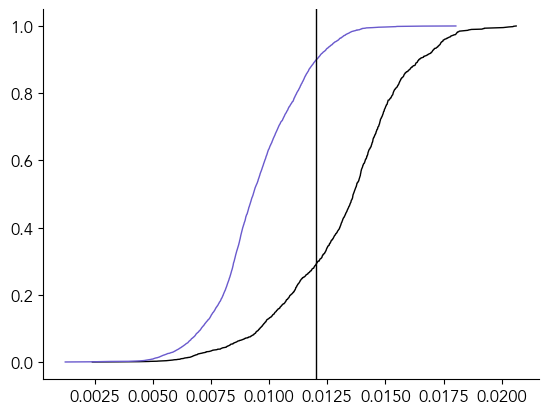

In [319]:
from sklearn.linear_model import LogisticRegression

x = 'all_aa_C'
y = 'oxygen'
data = df[~df[y].isnull()]

X = data[[x]].values
y_train = data[y].values
reg = LogisticRegression(random_state=0).fit(X, y_train)
y_pred = reg.predict(X)
p = 0.5
a = reg.intercept_[0]
b = reg.coef_[0][0]
threshold = (np.log(p/(1-p)) - a) / b
threshold, a, b


X1 = data[data['oxygen'] == 0][x].sort_values().values
X2 = data[data['oxygen'] == 1][x].sort_values().values

C1 = np.cumsum(X1) / np.sum(X1)
C2 = np.cumsum(X2) / np.sum(X2)

for threshold in np.linspace(X1.min(), X1.max(), 100):
    try:
        pass
        #print(np.max(C2[X2 < threshold]) - np.max(C1[X1 < threshold]), threshold, )
    except: 
        pass

threshold = 0.012
fig, ax = plt.subplots()
ax.plot(X1, C1)
ax.plot(X2, C2)
ax.axvline(threshold)

print(threshold)
print(1- np.max(C2[X2 < threshold]))
print(1-np.max(C1[X1 < threshold]))
print(np.max(C2[X2 < threshold]) - np.max(C1[X1 < threshold]))

## Energetic costs

In [234]:
costs = [['A', '11.7'],
 ['C', '24.7'],
 ['D', '12.7'],
 ['E', '15.3'],
 ['F', '52'],
 ['G', '11.7'],
 ['H', '38.3'],
 ['I', '32.3'],
 ['K', '30.3'],
 ['L', '27.3'],
 ['M', '34.3'],
 ['N', '14.7'],
 ['P', '20.3'],
 ['Q', '16.3'],
 ['R', '27.3'],
 ['S', '11.7'],
 ['T', '18.7'],
 ['V', '23.3'],
 ['W', '74.3'],
 ['Y', '50']]

aa_costs = {tup[0] : float(tup[1]) for tup in costs}
aa_costs

{'A': 11.7,
 'C': 24.7,
 'D': 12.7,
 'E': 15.3,
 'F': 52.0,
 'G': 11.7,
 'H': 38.3,
 'I': 32.3,
 'K': 30.3,
 'L': 27.3,
 'M': 34.3,
 'N': 14.7,
 'P': 20.3,
 'Q': 16.3,
 'R': 27.3,
 'S': 11.7,
 'T': 18.7,
 'V': 23.3,
 'W': 74.3,
 'Y': 50.0}

In [244]:
target = 'oxygen'

data = df[df[f"use_{target.replace('_optimum', '')}"] == True]
X = data[targets + all_all_features]
method = 'spearman'
C_all = X.corr(method=method).T

# grab 1 localization at a time
C_sers = []
for localization in localizations:
    ser = C_all.loc[target, prepend_features(heatmap_base_features[::-1], [localization])]
    ser.index = heatmap_base_features[::-1]
    C_sers.append(ser)

C = pd.concat(C_sers, axis=1)
    
#y_variables = heatmap_features = prepend_features(heatmap_base_features[::-1], [localization])
C.index = [rename_base_vars[y] for y in C.index]
C.columns = localizations
C['costs'] = C.index.map(aa_costs)
C = C[~C['costs'].isnull()]
C

(-0.6, 0.6)

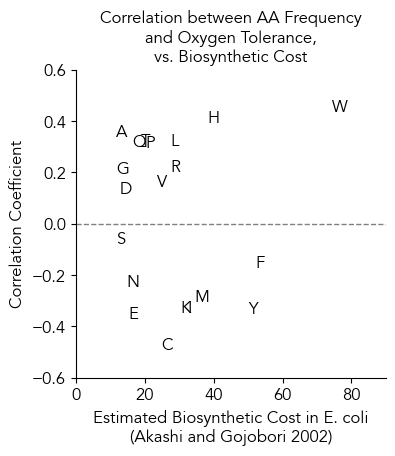

In [269]:
fig, ax = plt.subplots(figsize=(4,4))

X = C['costs']
Y = C['all']
L = C.index

for cost, corr, aa in zip(X,Y,L):
    ax.text(x=cost, y=corr, s=aa, fontsize=12)
ax.set_xlabel('Estimated Biosynthetic Cost in E. coli\n(Akashi and Gojobori 2002)')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Correlation between AA Frequency\nand Oxygen Tolerance,\nvs. Biosynthetic Cost')
ax.axhline(y=0, linestyle='--', color='gray')
ax.set_xlim([0,90])
ax.set_ylim([-0.6,0.6])

# Feature distributions by localization

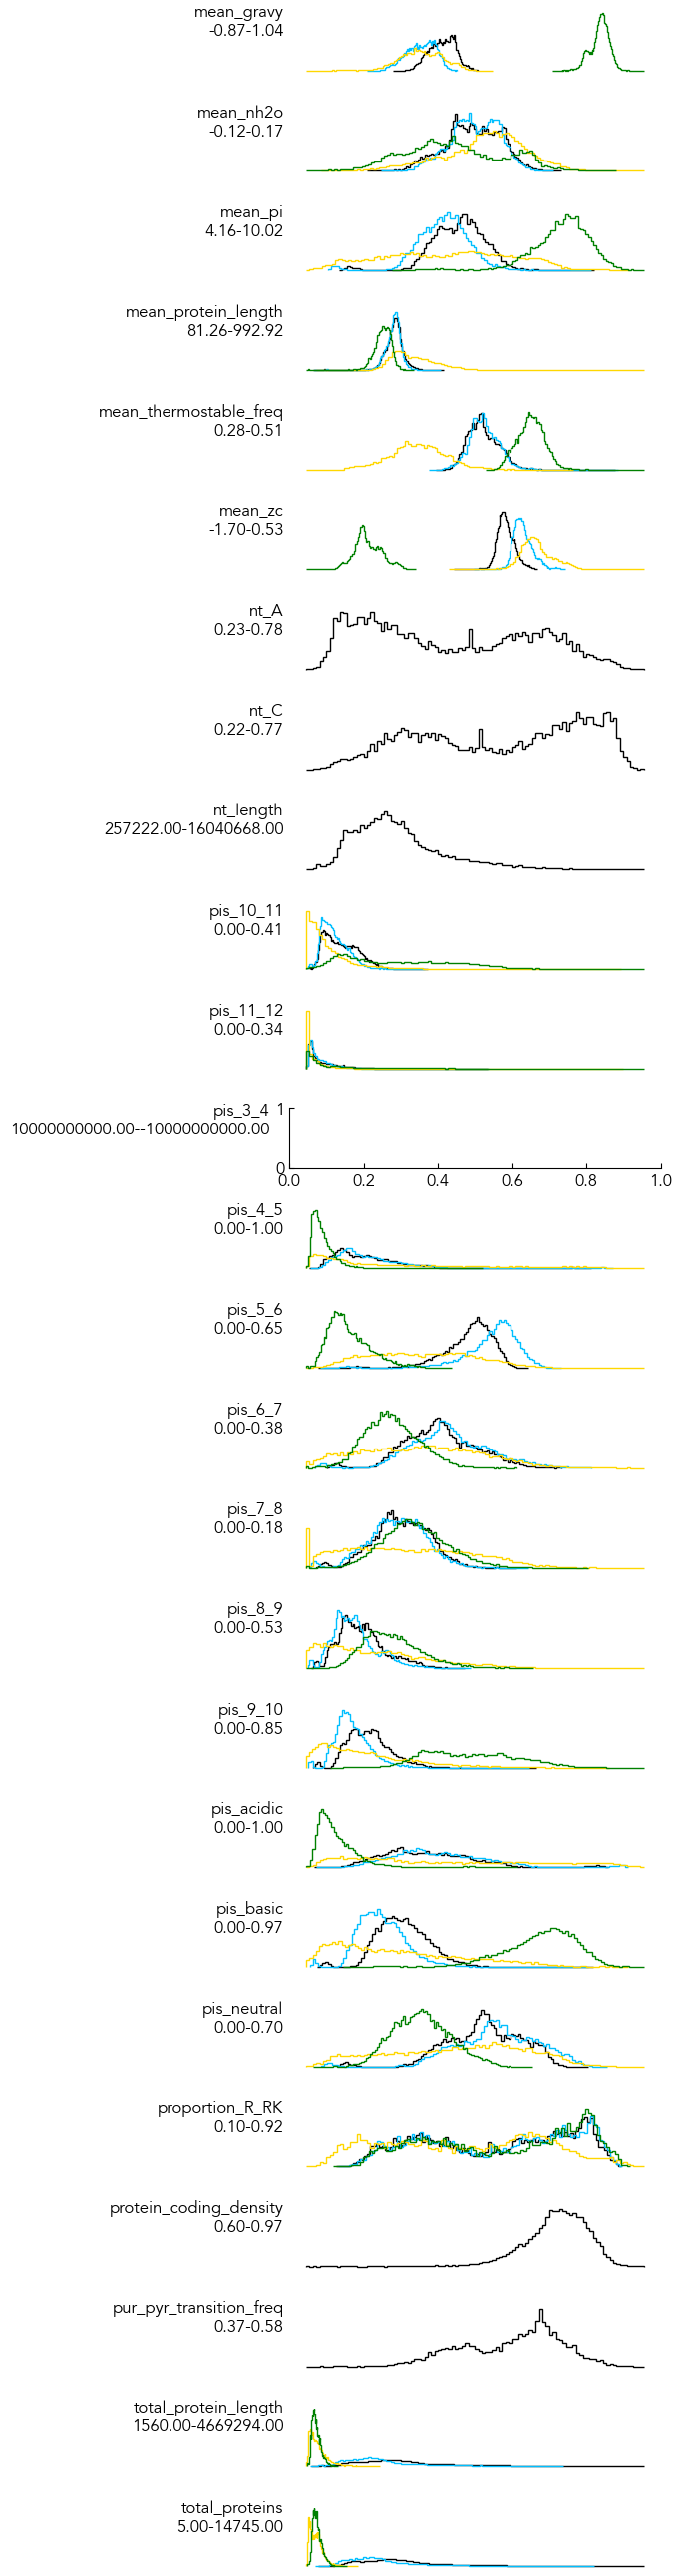

In [40]:
variables = derived_features


localization_colors = {'all' : 'black', 'intracellular_soluble' : 'deepskyblue', 'extracellular_soluble' : 'gold', 'membrane' : 'green'}

variables_sans_localization = set()
for var in variables:
    var = var.replace('intracellular_soluble_', '')
    var = var.replace('membrane_', '')
    var = var.replace('extracellular_soluble_', '')
    if var.startswith('all'):
        var = var.replace('all_', '')
    variables_sans_localization.add(var)

fig, axes = plt.subplots(len(variables_sans_localization), 1, figsize=(7, len(variables_sans_localization) * 1))
for n, var in enumerate(sorted(variables_sans_localization)):
    ax = axes[n]
    xmin = 1e10
    xmax = -1e10
    for localization, color in localization_colors.items():
        X = df_features[localization + '_' + var].values

        if np.sum(np.abs(X)) > 0:
            
            ax.hist(X, bins=100, histtype='step', color=color, clip_on=False, density=True)
            
            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            #ax.set_
            if X.min() < xmin:
                xmin = X.min()
            if X.max() > xmax:
                xmax = X.max()
            
    ax.set_ylabel(f'{var}\n{xmin:.2f}-{xmax:.2f}', rotation=0, ha='right')
    #ax.set_xticks([xmin, xmax])
            
plt.tight_layout()

# Unsupervised clustering

[24.47068096 18.11820497]


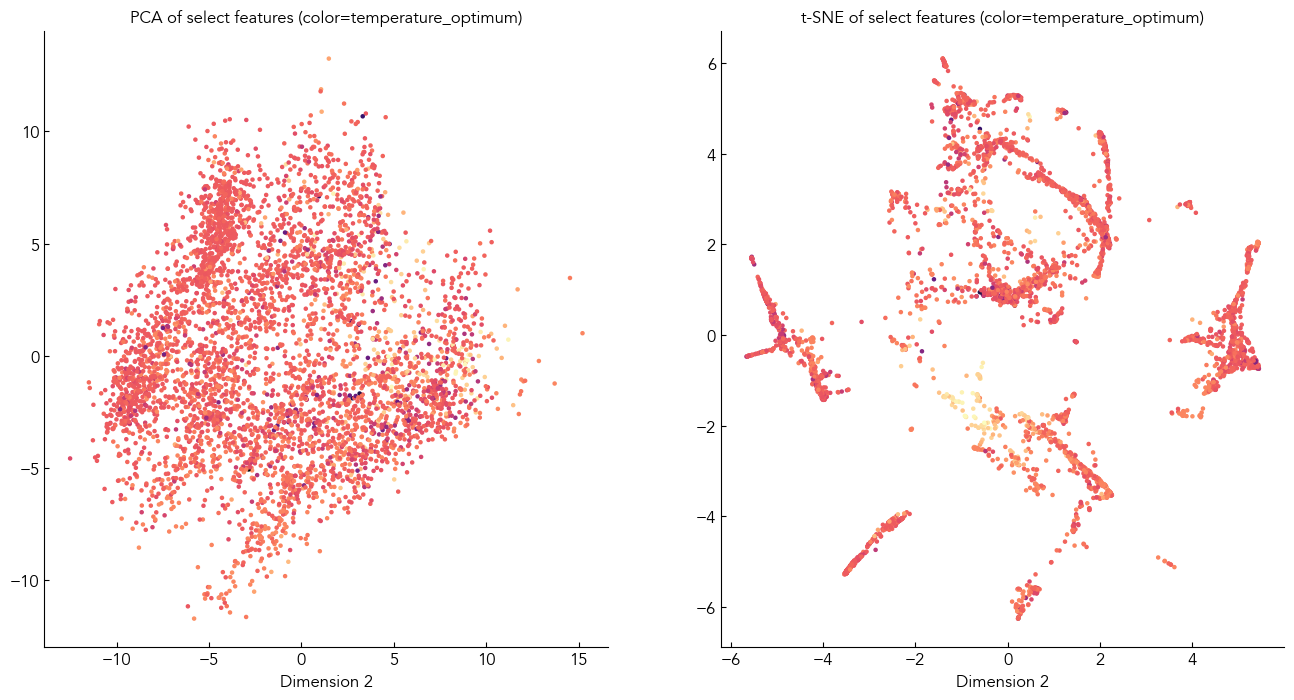

In [63]:
X = df[select_features]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print(pca.explained_variance_)

from sklearn.manifold import TSNE
t_sne = TSNE(
    n_components=2,
    perplexity=20,
    init="random",
    n_iter=250,
    random_state=0,
)

X_tsne = t_sne.fit_transform(X_scaled)
X_tsne.shape

c = 'temperature_optimum'
cmap = 'magma'

fig, axes = plt.subplots(1,2, figsize=(16,8))
size = 5
C = df[c]
ax = axes[0]

X_display = X_pca[~C.isnull()]
ax.scatter(X_display[:, 0], X_display[:, 1], c=np.log2(C[~C.isnull()]), alpha=1,  s=size, cmap=cmap)
ax.set_title(f'PCA of select features (color={c})')

ax = axes[1]
X_display = X_tsne[~C.isnull()]
ax.scatter(X_display[:, 0], X_display[:, 1], c=np.log2(C[~C.isnull()]) , alpha=1, s=size, cmap=cmap)
ax.set_title(f't-SNE of select features (color={c})')

for ax in axes:
    ax.set_xlabel('Dimension 1')
    ax.set_xlabel('Dimension 2')

In [940]:
# df[df['ncbi_species'].str.contains('Deinococcus radiodurans')]
# df[df['ncbi_species'].str.contains('Synechococcus')]
# df[df['ncbi_species'].str.contains('Corynebacterium glutamicum')]
df[df['ncbi_species'].str.contains('Tepidiforma')]
df[df['ncbi_species'].str.contains('Streptomyces albus')]
df[df['ncbi_species'].str.contains('Mycobacterium')].sort_values('ncbi_taxid')

,ncbi_taxid,strain_id,ncbi_species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,salinity_min,...,diff_extra_intra_aa_YI,diff_extra_intra_aa_QC,diff_extra_intra_aa_YC,diff_extra_intra_aa_CM,diff_extra_intra_aa_NM,diff_extra_intra_aa_CH,diff_extra_intra_aa_MC,diff_extra_intra_aa_CN,diff_extra_intra_protein_coding_density,ncbi_genus
GCA_000277125,1767.0,8403,Mycobacterium intracellulare subsp. intracellu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000128,0.000320,0.000396,0.000007,0.000246,0.000098,-0.000046,0.000282,0.0,Mycobacterium
GCA_900453675,1771.0,145275,Mycobacterium phlei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000059,0.000243,0.000090,-0.000082,0.000092,0.000054,-0.000126,0.000253,0.0,Mycobacterium
GCA_001457595,1772.0,8324,Mycobacterium smegmatis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000069,0.000115,-0.000014,-0.000079,0.000022,-0.000141,-0.000058,0.000278,0.0,Mycobacterium
GCA_025822665,1773.0,149307,Mycobacterium bovis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000123,-0.000121,0.000281,-0.000039,0.000121,-0.000041,-0.000012,0.000308,0.0,Mycobacterium
GCA_002982215,1773.0,135717,Mycobacterium microti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000039,-0.000179,0.000047,-0.000061,-0.000079,0.000005,-0.000094,0.000179,0.0,Mycobacterium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_002219285,NaN,8528,Mycobacterium intracellulare subsp. chimaera,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,0.000163,0.000477,0.000444,0.000021,0.000280,0.000110,0.000037,0.000491,0.0,Mycobacterium
GCA_002219265,NaN,139884,Mycobacterium intracellulare subsp. chimaera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000032,0.000349,0.000343,0.000023,0.000123,0.000033,-0.000031,0.000366,0.0,Mycobacterium
GCA_002705925,NaN,169695,Mycobacterium ostraviense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000210,0.000294,0.000161,-0.000022,0.000057,-0.000127,-0.000175,0.000498,0.0,Mycobacterium
GCA_019668465,NaN,169814,Mycobacterium senriense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000057,0.000372,0.000515,0.000023,0.000294,0.000052,-0.000036,0.000716,0.0,Mycobacterium


# PCA of amino acid composition

In [225]:
variables = ['extracellular_soluble_' + x for x in BASE_VARS_AAS] + ['intracellular_soluble_' + x for x in BASE_VARS_AAS]

X = df[variables]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn.decomposition import PCA, FactorAnalysis
pca = PCA(n_components=20)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print(pca.explained_variance_)


[20.49768966  4.76985611  2.89057438  2.03539204  1.62474744  1.11339254
  0.97894838  0.80757459  0.74835255  0.56640795  0.52434152  0.41795806
  0.36827429  0.2846884   0.26473855  0.24991625  0.21910983  0.17495952
  0.16021637  0.1533697 ]


In [ ]:
# fa = FactorAnalysis(n_components=10)
# fa.fit(X_pca)
# X_fa = fa.transform(X_pca)


In [220]:
compare = targets + ['all_nt_C'] #, 'all_protein_coding_density']
#compare = variables

In [226]:

df_pca = pd.DataFrame(X_pca)
df_pca.columns = ['pc'+str(1+col) for col in df_pca.columns]
pcs = df_pca.columns
df_pca.index = df.index
df_pca = pd.concat([df_pca, df[compare]], axis=1)

df_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc16,pc17,pc18,pc19,pc20,oxygen,temperature_optimum,salinity_optimum,ph_optimum,all_nt_C
GCA_000425045,2.004145,-0.095703,-1.055003,-1.113625,1.342130,-1.910586,0.301147,-0.143774,-0.368508,-0.725222,...,-0.676582,0.061623,0.005508,0.465612,0.029650,0.0,NaN,NaN,NaN,0.499959
GCA_000025305,0.802257,-1.396526,-1.514149,-0.597042,0.594379,-1.526773,0.742694,-0.427696,-0.682662,-0.187365,...,-0.406436,0.081601,0.689342,0.122775,-0.056180,0.0,NaN,NaN,NaN,0.558427
GCA_003385765,5.940044,2.110626,0.590227,1.088706,-1.607225,0.422602,-1.604412,-2.060695,-0.321889,-0.565438,...,-0.070436,0.606710,-1.237301,-0.067894,0.112843,NaN,NaN,NaN,NaN,0.318669
GCA_003207865,-3.969523,-2.375746,0.716976,-1.489948,2.109998,-0.863742,-1.165586,-0.332498,-1.846020,-0.140155,...,0.212358,-0.007161,0.378254,-0.274234,0.596315,NaN,NaN,NaN,NaN,0.623306
GCA_003207855,-4.182793,-2.366556,0.833926,-1.710696,2.424703,-1.140599,-1.418358,-0.310295,-1.905297,-0.047865,...,0.375321,0.160480,0.305673,-0.152749,0.610629,NaN,NaN,NaN,NaN,0.634926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_009928525,2.924026,-1.420767,1.249779,0.975071,1.259421,0.324894,-0.804149,-1.061497,-0.711480,-0.525350,...,-0.216352,-0.308098,0.033650,0.561264,0.252656,NaN,NaN,NaN,NaN,0.486299
GCA_020042285,6.005577,1.700623,2.466832,3.429453,1.769445,1.998469,-0.228334,-0.024597,0.476175,-0.614567,...,0.656158,0.096700,-0.384152,-0.189945,0.597326,NaN,NaN,NaN,NaN,0.366515
GCA_020042345,3.781420,-1.018677,1.334563,1.262090,1.114817,1.752096,-1.109353,-0.994286,-0.864731,1.002187,...,0.245976,0.088514,0.086741,0.764503,0.384830,NaN,NaN,NaN,NaN,0.437816
GCA_021538615,3.022637,-1.147833,0.878573,2.012808,1.014523,0.564306,-0.685095,-1.006229,-0.933984,-0.220012,...,0.076695,-0.273996,0.145385,0.813844,0.143679,NaN,NaN,NaN,NaN,0.471333


In [227]:
BASE_VARS_DERIVED_GENOME

['nt_C',
 'pur_pyr_transition_freq',
 'protein_coding_density',
 'mean_protein_length']

In [228]:
C = df_pca.corr(method='spearman')

C = C.loc[pcs, compare] #
C['explained_variance'] = pca.explained_variance_ratio_
#C['cumsum_explained_variance'] = np.cumsum(pca.explained_variance_ratio_)

C.style.background_gradient(cmap='RdBu_r', vmin=-1, vmax=1)

,oxygen,temperature_optimum,salinity_optimum,ph_optimum,all_nt_C,explained_variance
pc1,-0.316698,0.112189,0.033538,0.025813,-0.979984,0.512409
pc2,-0.150573,-0.022773,0.138518,0.050132,0.023434,0.119239
pc3,0.417734,-0.264485,-0.152839,-0.190192,-0.042008,0.072260
pc4,-0.037830,-0.172383,-0.503602,-0.272733,0.063555,0.050882
pc5,-0.314033,-0.121798,-0.156418,-0.225176,0.020041,0.040616
pc6,0.304675,-0.219177,0.305912,0.235748,-0.006930,0.027833
pc7,-0.309176,0.164594,0.121114,-0.000600,0.036424,0.024472
pc8,-0.014404,-0.046154,-0.042574,-0.080714,0.056645,0.020188
pc9,-0.142222,-0.084439,-0.054207,0.021918,0.007893,0.018708
pc10,-0.021180,0.049049,0.027148,-0.118675,0.082543,0.014159


Text(0, 0.5, 'dim4')

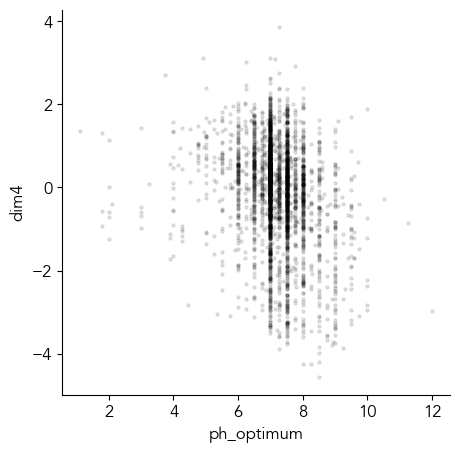

In [166]:
fig , ax = plt.subplots(figsize=(5,5))

x = 'ph_optimum'
y = 'dim4'

X = df_pca[x]
Y = df_pca[y]
ax.scatter(X, Y, s=5, alpha=0.1)
ax.set_xlabel(x)
ax.set_ylabel(y)

Text(0, 0.5, 'oxygen')

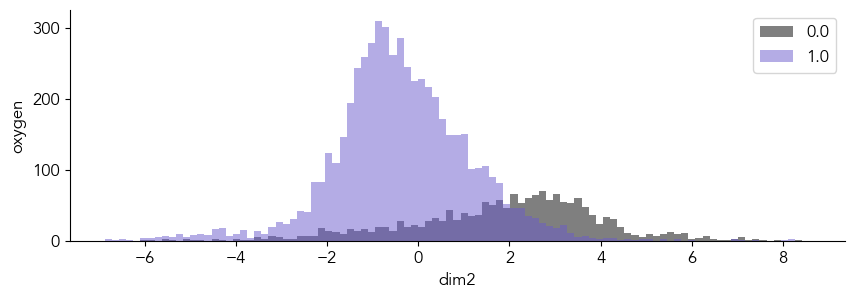

In [154]:
fig , ax = plt.subplots(figsize=(10,3))

x = 'dim2'
X = df_pca[x]
bins = np.linspace(X.min(), X.max(), 100)

y = 'oxygen'
for name, group in df_pca.groupby(y):
    ax.hist(group[x], bins=bins, alpha=0.5, label=name)

#ax.scatter(X, Y, s=5, alpha=0.1)
ax.legend()
ax.set_xlabel(x)
ax.set_ylabel(y)